In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.patches import Patch

Matplotlib is building the font cache; this may take a moment.


In [2]:
time = 365
inc = 28
inf = 7

In [3]:
def create_hh():
    hh_size = np.random.choice([3, 4, 5, 6], size = 340, replace = True)
    hh_size = hh_size[np.cumsum(hh_size) < 1000]
    
    leftover = 1000 - hh_size.sum()
    if leftover < 3:
        # Randomly sample leftover amount indices from hh_size, and add one
        hh = np.arange(len(hh_size))
        idx = np.random.choice(hh[hh_size < 6], size = leftover, replace = False)
        hh_size[idx] += 1
    else:
        hh_size = np.append(hh_size, leftover)
    return hh_size

In [4]:
def SEIR(beta_H, beta_C, inc, inf):
    hh_size = create_hh()
    
    data = pd.DataFrame({'ID': range(1000),
                         'SIZE': np.repeat(hh_size, repeats = hh_size),
                         'HH': np.repeat(range(len(hh_size)), repeats = hh_size),
                         'S': np.append(0, np.ones(999)),
                         'E': np.append(1, np.zeros(999)),
                         'E_count': np.append(1, np.zeros(999)),
                         'I': np.zeros(1000),
                         'I_count': np.zeros(1000),
                         'R': np.zeros(1000),
                         'INC': np.append(np.round(stats.norm.rvs(inc, 2)), np.zeros(999)),
                         'INF': np.zeros(1000)
                        })
    
    results = data.loc[:, 'ID':'HH']
    results['TYPE'] = np.nan
    results.loc[0, 'TYPE'] = '0'
    results['TIME'] = np.nan
    results.loc[0, 'TIME'] = 0
    
    for t in range(time):
        if t % 10 == 0: print(t, end = ' ')
        recovered = (data['INF'] > 0) & (data['I_count'] == data['INF'])
        if sum(recovered) > 0:
            data.loc[recovered, 'R'] = 1
            data.loc[recovered, 'I'] = 0

            # Why is this count set to 0 once they recover?
            data.loc[recovered, 'I_count'] = 0

        new_inf = (data['INC'] > 0) & (data['E_count'] == data['INC'])
        num_new_inf = sum(new_inf)

        if num_new_inf > 0:
            # Why do new infections have SD = 1?
            random_inf = np.round(stats.norm.rvs(inf, 1, size = num_new_inf))
            data.loc[new_inf, 'I'] = 1
            data.loc[new_inf, 'INF'] = random_inf
            data.loc[new_inf, 'E'] = 0

            # Why is this set to 0?
            data.loc[new_inf, 'E_count'] = 0

        I_H = data.groupby('HH').sum()['I']
        summary = pd.DataFrame({'I_H': I_H, 
                                'I_C': data.sum()['I'] - I_H
                               })
        dd = data[['HH', 'S']].copy()

        dd['I_H'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_H'], axis = 1)
        dd['I_C'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_C'], axis = 1)

        risk_H = dd['S'] * beta_H * dd['I_H'] / 1000
        risk_C = dd['S'] * beta_C * dd['I_C'] / 1000

        new_inf_H = stats.binom.rvs(1, risk_H, size = data.shape[0])
        new_inf_C = stats.binom.rvs(1, risk_C, size = data.shape[0])
        new_exposed = (new_inf_H == 1) | (new_inf_C == 1)

        num_new_exposed = sum(new_exposed)
        if num_new_exposed > 0:
            data.loc[new_exposed, 'E'] = 1
            # Why is this calculated only upon exposure?
            random_inc = np.round(stats.norm.rvs(inc, 2, size = num_new_exposed))
            data.loc[new_exposed, 'E'] = 1
            data.loc[new_exposed, 'INC'] = random_inc

            results['TYPE'].where(~((new_inf_H == 1) & (new_inf_C == 1)) | ~pd.isna(results['TYPE']), 'B', inplace = True)
            results['TYPE'].where(~(new_inf_H == 1) | ~pd.isna(results['TYPE']), 'H', inplace = True)
            results['TYPE'].where(~(new_inf_C == 1) | ~pd.isna(results['TYPE']), 'C', inplace = True)
            results['TIME'].where(~(new_exposed == 1) | ~pd.isna(results['TIME']), t, inplace = True)
        
        data.loc[data['E'] == 1, 'E_count'] += 1
        data.loc[data['I'] == 1, 'I_count'] += 1
        data.loc[data['E'] == 1, 'S'] = 0

    return results
        

In [5]:
def metrics(results):
    state = results[~pd.isna(results['TIME'])]
    incidence = state.shape[0]/1000
    
    prop_hh = np.nan
    if incidence != 0:
        prop_hh = state[state['TYPE'] == 'H'].shape[0] / state.shape[0]
    
    return incidence, prop_hh

In [6]:
def mse(results, target):
    return ((np.array(metrics(results)) - target)**2).sum()

def bce(results, target):
    incidence, prop_hh = metrics(results)
    
    incidence_loss = target[0] * np.log(incidence + eps) + (1 - target[0]) * np.log(1 - incidence + eps)
    prop_hh_loss = target[1] * np.log(prop_hh + eps) + (1 - target[1]) * np.log(1 - prop_hh + eps)
    return incidence_loss + prop_hh_loss

# 10 February

In [ ]:
idcs = np.load('results/archive/idcs_3.npy')
prps = np.load('results/archive/prps_3.npy')

beta_C_vals = np.load('results/archive/beta_C_vals_3.npy')
beta_H_vals = np.load('results/archive/beta_H_vals_3.npy')
cc, hh = np.meshgrid(beta_C_vals, beta_H_vals)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (9.5, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
plt.colorbar(plot_hh, ax = axs[0])

axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)
axs[0].set_title(r'$\beta_H$', loc = 'left')

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
plt.colorbar(plot_cc, ax = axs[1])

axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)
axs[1].set_title(r'$\beta_C$', loc = 'left')

plt.savefig('plots/prp_vs_inc_1.png', transparent = True, dpi = 300)

In [ ]:
idx = (idcs >= 0.09) & (idcs <= 0.11) & (prps >= 0.2) & (prps <= 0.3)

In [ ]:
hh[idx], cc[idx]

In [ ]:
hh

In [ ]:
cc

In [ ]:
results = SEIR(23.8, 0.22, num_weeks_inf, num_weeks_inc)

In [ ]:
metrics(results)

## More Results

In [ ]:
idcs = np.load('results/1/idcs.npy')
prps = np.load('results/1/prps.npy')

cc = np.load('results/1/cc.npy')
hh = np.load('results/1/hh.npy')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (9.5, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), 
                         c = np.repeat(hh.flatten(), 5), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), 
                         c = np.repeat(cc.flatten(), 5), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('prp_vs_inc_2.png', transparent = True, dpi = 300)

# 14 February

Results for a $\beta_H$ grid of $[20, 20.8, 21.6, \ldots, 39.2, 40]$ and $\beta_C$ grid of $[0, 0.04, 0.08, \ldots, 0.96, 1]$.

In [ ]:
idcs = np.load('results/2/idcs.npy')
prps = np.load('results/2/prps.npy')

cc = np.load('results/2/cc.npy')
hh = np.load('results/2/hh.npy')

In [ ]:
mean_idcs = idcs.mean(axis = 2)
mean_prps = prps.mean(axis = 2)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)

axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_inc_2.png', transparent = True, dpi = 300)

Results for a $\beta_H$ grid of $[10, 12, 14, \ldots, 48, 50]$ and $\beta_C$ grid of $[0, 0.1, 0.2, \ldots, 1.9, 2]$.

In [ ]:
idcs = np.load('results/3/idcs_3.npy')
prps = np.load('results/3/prps_3.npy')

cc = np.load('results/3/cc_3.npy')
hh = np.load('results/3/hh_3.npy')

In [ ]:
mean_idcs = idcs.mean(axis = 2)
mean_prps = prps.mean(axis = 2)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_inc_3.png', transparent = True, dpi = 300)

# 15 February

In [ ]:
idcs_1 = np.load('results/4/idcs_1.npy')
prps_1 = np.load('results/4/prps_1.npy')

idcs_2 = np.load('results/4/idcs_2.npy')
prps_2 = np.load('results/4/prps_2.npy')

idcs_3 = np.load('results/4/idcs_3.npy')
prps_3 = np.load('results/4/prps_3.npy')

beta_H_vals = [20.6, 30, 29.6]
beta_C_vals = [0.30, 0.12, 0.20]

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (10, 16))
bins = np.linspace(0, 1, 51)

axs[0][0].hist(idcs_1, bins = bins)
axs[0][1].hist(prps_1, bins = bins)
axs[0][0].set_xlim(0, 1)
axs[0][1].set_xlim(0, 1)
axs[0][0].set_title(r'$\beta_H = 20.6$, $\beta_C = 0.30$', loc = 'left')
axs[0][0].set_xlabel('Incidence')
axs[0][1].set_xlabel('Proportion HH')

axs[1][0].hist(idcs_2, bins = bins)
axs[1][1].hist(prps_2, bins = bins)
axs[1][0].set_xlim(0, 1)
axs[1][1].set_xlim(0, 1)
axs[1][0].set_title(r'$\beta_H = 30$, $\beta_C = 0.12$', loc = 'left')
axs[1][0].set_xlabel('Incidence')
axs[1][1].set_xlabel('Proportion of Infections from Household')

axs[2][0].hist(idcs_3, bins = bins)
axs[2][1].hist(prps_3, bins = bins)
axs[2][0].set_xlim(0, 1)
axs[2][1].set_xlim(0, 1)
axs[2][0].set_title(r'$\beta_H = 29.6$, $\beta_C = 0.20$', loc = 'left')
axs[2][0].set_xlabel('Incidence')
axs[2][1].set_xlabel('Proportion of Infections from Household')
plt.savefig('plots/param_check.png', transparent = False, dpi = 300)

In [ ]:
idcs_1.mean(), prps_1.mean()

In [ ]:
idcs_2.mean(), prps_2.mean()

In [ ]:
idcs_3.mean(), prps_3.mean()

In [ ]:
idcs_3[prps_3 == 1]

In [ ]:
prps_1[idcs_1 == 0]

In [ ]:
prps_2[idcs_2 == 0]

In [ ]:
prps_3[idcs_3 == 0]

# 28 February

In [ ]:
def metrics(results):
    state = results[~pd.isna(results['TIME'])]
    i = state.shape[0]/1000
    
    #p_hh = np.nan
    #if i != 0:
    #    p_hh = state[state['TYPE'] == 'H'].shape[0] / state.shape[0]
    #return i, p_hh
    
    sar = np.nan
    if i != 0:
        num_primary = np.sum(results.groupby('HH')['TIME'].sum() > 0) # households that were infected
        idx = results.groupby('HH')['TYPE'].apply(lambda x: ~np.all(x.isna()))
        num_contact = (results.groupby('HH')['SIZE'].sum()[idx]**(1/2)).sum() # total people in all those households
        sar = state[(state['TYPE'] == 'H') | (state['TYPE'] == 'B')].shape[0] / (num_contact - num_primary)
    
    return i, sar

In [ ]:
chain = np.load('results/5/chain_2.npy')

In [ ]:
from matplotlib.collections import LineCollection

x = chain[:, 0]
y = chain[:, 1]
cs = np.linspace(0,1,len(x))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots()
lc = LineCollection(segments, cmap='viridis')
lc.set_array(cs)
lc.set_linewidth(1)
line = ax.add_collection(lc)
ax.autoscale()
plt.xlabel(r'$\beta_H$')
plt.ylabel(r'$\beta_C$')
# Plot loss value over iterations
# Deliverables
# Update MCMC (by Wednesday)
# - save likelihood
# - each iteration averages over 100 iterations (NUM_ITER)
# Implement SAR (by Friday)
# Test R code on local device

In [ ]:
best = np.load('results/5/best_2.npy')

In [ ]:
beta_H, beta_C = best

In [ ]:
idcs = np.load('results/6/idcs_5.npy')
sars = np.load('results/6/sars_5.npy')

cc = np.load('results/6/cc_5.npy')
hh = np.load('results/6/hh_5.npy')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), sars.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$\rm SAR$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), sars.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$\rm SAR$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_sar.png', transparent = True, dpi = 300)

In [ ]:
cc[(idcs > 0.05) & (idcs < 0.15)]

In [ ]:
hh[(idcs > 0.05) & (idcs < 0.15)]

In [ ]:
cc[(idcs > 0.25) & (idcs < 0.35)]

In [ ]:
hh[(idcs > 0.25) & (idcs < 0.35)]

In [ ]:
cc[(idcs > 0.01) & (idcs < 0.07)]

In [ ]:
hh[(idcs > 0.01) & (idcs < 0.07)]

In [ ]:
beta_Hs = np.linspace(5, 35, 61)
beta_Cs = np.linspace(0, 1, 21)

In [ ]:
beta_Hs

In [ ]:
i = 1, j = 0

In [ ]:
for i in range(3):
    for j in range(4):
        for k in range(5):
            print(20*i + 5*j + k)

In [ ]:
%%time
SEIR(beta_H, beta_C, inc, inf)

In [ ]:
beta_H, beta_C

In [ ]:
n = 25
sars = [None]*n
idcs = [None]*n
for i in range(n):
    print(i, end = ' ')
    results = SEIR(beta_H, beta_C, inc, inf)
    idc, sar = metrics(results)
    idcs[i] = idc
    sars[i] = sar
    print()

In [ ]:
np.mean(idcs)

In [ ]:
plt.hist(idcs, alpha = 0.5)

In [ ]:
np.mean(sars)

In [ ]:
plt.hist(sars, alpha = 0.5)

In [ ]:
chain

In [ ]:
np.unique(chain).shape

In [ ]:
np.prod(chain.shape)

# 6 March 

In [ ]:
best = np.load('results/8/best.npy')
liks = np.load('results/8/liks.npy')

In [ ]:
best

In [ ]:
liks[:, 0]

In [ ]:
# How many simulations per parameter set: Pick 5 parameter sets and check them on different simulation sizes (10, 50, 100, 250, 500, 750, 1000)
# Sophia will test on Winton
# Paralellize code
# MCMC fits to stochastic models: harder to find the global optimum. Initial guess makes a big difference.
# Grid search to get better initial guess.

In [ ]:
chain

In [ ]:
plt.plot(chain[:, 0], chain[:, 1])

In [ ]:
plt.plot(liks[:, 0])

In [ ]:
chain = np.load('results/8/chain.npy')

In [ ]:
chain

# 15 March

## Grid Search

In [ ]:
idcs = np.load('results/9/idcs.npy')
sars = np.load('results/9/sars.npy')

cc = np.load('results/9/cc.npy')
hh = np.load('results/9/hh.npy')

In [ ]:
idcs.shape

In [ ]:
np.sum(np.isnan(idcs))

In [ ]:
sars

In [ ]:
mean_idcs = idcs.mean(axis = 2)
mean_sars = sars.mean(axis = 2)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_sars.flatten(), 
                         c = hh.flatten(), alpha = 0.5)

axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'${\rm SAR}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_sars.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'${\rm SAR}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/sar_vs_idc.png', transparent = True, dpi = 300)

In [ ]:
def create_hh():
    hh_size = np.random.choice([3, 4, 5, 6], size = 340, replace = True)
    hh_size = hh_size[np.cumsum(hh_size) < 1000]
    
    leftover = 1000 - hh_size.sum()
    if leftover < 3:
        # Randomly sample leftover amount indices from hh_size, and add one
        hh = np.arange(len(hh_size))
        idx = np.random.choice(hh[hh_size < 6], size = leftover, replace = False)
        hh_size[idx] += 1
    else:
        hh_size = np.append(hh_size, leftover)
    return hh_size

def SEIR(beta_H, beta_C, inc, inf, verbose = 0):
    hh_size = create_hh()
    
    # ID: ID of individual
    # SIZE: size of individual's household
    # HH: ID of individual's household
    # S: susceptibility status
    # E: exposed status
    # E_count: number of days since exposed
    # I: infectious status
    # I_count: number of days since infectious
    # R: recovered status
    # INC: incubation period
    # INF: infectious period
    # S_num: number of susceptible people in household when infectious period begins
    # I_num: number of people that this person infected over the infectious period
    data = pd.DataFrame({'ID': range(1000),
                         'SIZE': np.repeat(hh_size, repeats = hh_size),
                         'HH': np.repeat(range(len(hh_size)), repeats = hh_size),
                         'S': np.append(0, np.ones(999)),
                         'E': np.append(1, np.zeros(999)),
                         'E_count': np.append(1, np.zeros(999)),
                         'I': np.zeros(1000),
                         'I_count': np.zeros(1000),
                         'R': np.zeros(1000),
                         'INC': np.append(np.round(stats.norm.rvs(inc, 2)), np.zeros(999)),
                         'INF': np.zeros(1000)
                        })
    
    # Create frame for storing results
    results = data.loc[:, 'ID':'HH']
    results['TYPE'] = np.nan
    results.loc[0, 'TYPE'] = 'I' # index case is Type 0 
    results['TIME'] = np.nan
    #results['TIME_I'] = np.nan
    #results['TIME_E'] = np.nan
    results['S_num'] = np.nan
    results['I_num'] = 0
    
    for t in range(time):
        if verbose:
            if t % 10 == 0: print(t, end = ' ')
        
        # Anyone who has been infectious for as many days as their infectious
        # period is now recovered.
        recovered = (data['INF'] > 0) & (data['I_count'] == data['INF'])
        if sum(recovered) > 0:
            data.loc[recovered, 'R'] = 1
            data.loc[recovered, 'I'] = 0
            data.loc[recovered, 'I_count'] = 0

        # Anyone who has been incubating for as many days as their incubation
        # period is now infectious.
        new_inf = (data['INC'] > 0) & (data['E_count'] == data['INC'])
        num_new_inf = sum(new_inf)
        if num_new_inf > 0:
            random_inf = np.round(stats.norm.rvs(inf, 1, size = num_new_inf))
            data.loc[new_inf, 'I'] = 1
            data.loc[new_inf, 'INF'] = random_inf
            data.loc[new_inf, 'E'] = 0
            data.loc[new_inf, 'E_count'] = 0
            
            # If newly infected and there isn't already a time recorded, then update with the time t.
            results['TIME'].where(~(new_inf == 1) | ~pd.isna(results['TIME']), t, inplace = True)
            #results['TIME_I'].where(~(new_inf == 1) | ~pd.isna(results['TIME_I']), t, inplace = True)
            
            # Get the number of susceptible people in each household
            S_num = data.groupby('HH').sum()

            # Get the households of the newly infectious people
            hh_idx = data.loc[new_inf, :]['HH']
            
            # Save in results the number of susceptible people
            results.loc[new_inf, 'S_num'] = S_num.loc[hh_idx, 'S'].values
            
        # I_H is the number of infections in each household.
        # I_C is the number of infections outside a given household.
        I_H = data.groupby('HH').sum()['I']
        summary = pd.DataFrame({'I_H': I_H, 
                                'I_C': data.sum()['I'] - I_H
                               })
        # dd is a frame where each individual is assigned their household's
        # I_H and I_C numbers.
        dd = data[['HH', 'S']].copy()
        dd['I_H'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_H'], axis = 1)
        dd['I_C'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_C'], axis = 1)

        # Calculate household risk and community risk
        risk_H = dd['S'] * beta_H * dd['I_H'] / 1000
        risk_C = dd['S'] * beta_C * dd['I_C'] / 1000

        # Calculate new household and community infections
        new_inf_H = stats.binom.rvs(1, risk_H, size = data.shape[0])
        new_inf_C = stats.binom.rvs(1, risk_C, size = data.shape[0])
        new_exposed = (new_inf_H == 1) | (new_inf_C == 1)

        num_new_exposed = sum(new_exposed)
        if num_new_exposed > 0:
            data.loc[new_exposed, 'E'] = 1
            random_inc = np.round(stats.norm.rvs(inc, 2, size = num_new_exposed))
            data.loc[new_exposed, 'E'] = 1
            data.loc[new_exposed, 'INC'] = random_inc
            
            #print(np.sum( (new_inf_H == 1) & (~pd.isna(results['TYPE'])) ))
            # The NA checks may not be necessary, since S = 0 for anyone who already has been assigned a TYPE
            results['TYPE'].where(~(new_inf_H == 1) | ~pd.isna(results['TYPE']), 'H', inplace = True)
            results['TYPE'].where(~(new_inf_C == 1) | ~pd.isna(results['TYPE']), 'C', inplace = True)
            #results['TIME_E'].where(~(new_exposed == 1) | ~pd.isna(results['TIME_E']), t, inplace = True)
            
            # Number of new infections in each household
            rr = results.loc[new_inf_H == 1, :].groupby('HH')['TYPE'].count()
            
            # Get individuals with the smallest infectious counts
            ids = data[data['I'] == 1].groupby('HH').min()['ID']
            
            # Increase I_num by the amount of people in household that got a H-type infection
            res_idx = results['ID'].isin(ids) & (results['HH'].isin(rr.index))
            results.loc[res_idx, 'I_num'] += rr.values
            
            # After the above analysis, assign 'B' to people who were infected by both.
            results['TYPE'].where(~((new_inf_H == 1) & (new_inf_C == 1)) | ~pd.isna(results['TYPE']), 'B', inplace = True)
            
        data.loc[data['E'] == 1, 'E_count'] += 1
        data.loc[data['I'] == 1, 'I_count'] += 1
        data.loc[data['E'] == 1, 'S'] = 0

    return results

def metrics(results):
    state = results[~pd.isna(results['TIME'])]
    idc = state.shape[0]/1000
    
    sar = np.nan
    if idc != 0:
        sar = np.mean(results['I_num'] / results['S_num'])
    
    return idc, sar

def score(results, target):
    return np.sum((np.array(metrics(results)) - target)**2)

In [ ]:
beta_H = hh[20][20]
beta_C = cc[10][10]

In [ ]:
beta_H

In [ ]:
beta_C

In [ ]:
results = SEIR(beta_H, beta_C, inc, inf)

In [ ]:
metrics(results)

## Variance Check

### Case 1

For Case 1, 
- $\beta_H = 30$;
- $\beta_C = 0.12$.

In [ ]:
idcs_10 = np.load('results/8/idcs_1_10.npy')
idcs_50 = np.load('results/8/idcs_1_50.npy')
idcs_100 = np.load('results/8/idcs_1_100.npy')
idcs_250 = np.load('results/8/idcs_1_250.npy')
idcs_500 = np.load('results/8/idcs_1_500.npy')
idcs_750 = np.load('results/8/idcs_1_750.npy')
idcs_1000 = np.load('results/8/idcs_1_1000.npy')

sars_10 = np.load('results/8/sars_1_10.npy')
sars_50 = np.load('results/8/sars_1_50.npy')
sars_100 = np.load('results/8/sars_1_100.npy')
sars_250 = np.load('results/8/sars_1_250.npy')
sars_500 = np.load('results/8/sars_1_500.npy')
sars_750 = np.load('results/8/sars_1_750.npy')
sars_1000 = np.load('results/8/sars_1_1000.npy')

n_10 = np.arange(1, 11)
n_50 = np.arange(1, 51)
n_100 = np.arange(1, 101)
n_250 = np.arange(1, 251)
n_500 = np.arange(1, 501)
n_750 = np.arange(1, 751)
n_1000 = np.arange(1, 1001)

In [ ]:
idc_avg_10 = np.cumsum(idcs_10) / n_10
idc_avg_50 = np.cumsum(idcs_50) / n_50
idc_avg_100 = np.cumsum(idcs_100) / n_100
idc_avg_250 = np.cumsum(idcs_250) / n_250
idc_avg_500 = np.cumsum(idcs_500) / n_500
idc_avg_750 = np.cumsum(idcs_750) / n_750
idc_avg_1000 = np.cumsum(idcs_1000) / n_1000

sar_avg_10 = np.cumsum(sars_10) / n_10
sar_avg_50 = np.cumsum(sars_50) / n_50
sar_avg_100 = np.cumsum(sars_100) / n_100
sar_avg_250 = np.cumsum(sars_250) / n_250
sar_avg_500 = np.cumsum(sars_500) / n_500
sar_avg_750 = np.cumsum(sars_750) / n_750
sar_avg_1000 = np.cumsum(sars_1000) / n_1000

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

axs[0].plot(n_10, idc_avg_10, alpha = 0.75)
axs[0].plot(n_50, idc_avg_50, alpha = 0.75)
axs[0].plot(n_100, idc_avg_100, alpha = 0.75)
axs[0].plot(n_250, idc_avg_250, alpha = 0.75)
axs[0].plot(n_500, idc_avg_500, alpha = 0.75)
axs[0].plot(n_750, idc_avg_750, alpha = 0.75)
axs[0].plot(n_1000, idc_avg_1000, alpha = 0.75)
axs[0].set_xlabel('Number of Simulations')
axs[0].set_ylabel('Average Incidence')
axs[0].set_title(r'$\beta_H = 30$, $\beta_C = 0.12$', loc = 'left')
axs[0].set_title(r'Convergence of Incidence', loc = 'left')

axs[1].plot(n_10, sar_avg_10, alpha = 0.75)
axs[1].plot(n_50, sar_avg_50, alpha = 0.75)
axs[1].plot(n_100, sar_avg_100, alpha = 0.75)
axs[1].plot(n_250, sar_avg_250, alpha = 0.75)
axs[1].plot(n_500, sar_avg_500, alpha = 0.75)
axs[1].plot(n_750, sar_avg_750, alpha = 0.75)
axs[1].plot(n_1000, sar_avg_1000, alpha = 0.75)
axs[1].set_xlabel('Number of Simulations')
axs[1].set_ylabel('Average SAR')
axs[1].set_title(r'$\beta_H = 30$, $\beta_C = 0.12$', loc = 'left')
axs[1].set_title(r'Convergence of SAR', loc = 'left')

plt.savefig('plots/case_1.png', bbox_inches = 'tight', dpi = 300)

### Case 2

For Case 2, 
- $\beta_H = 23$;
- $\beta_C = 0.1$.

In [ ]:
idcs_10 = np.load('results/8/idcs_2_10.npy')
idcs_50 = np.load('results/8/idcs_2_50.npy')
idcs_100 = np.load('results/8/idcs_2_100.npy')
idcs_250 = np.load('results/8/idcs_2_250.npy')
idcs_500 = np.load('results/8/idcs_2_500.npy')
idcs_750 = np.load('results/8/idcs_2_750.npy')
idcs_1000 = np.load('results/8/idcs_2_1000.npy')

sars_10 = np.load('results/8/sars_2_10.npy')
sars_50 = np.load('results/8/sars_2_50.npy')
sars_100 = np.load('results/8/sars_2_100.npy')
sars_250 = np.load('results/8/sars_2_250.npy')
sars_500 = np.load('results/8/sars_2_500.npy')
sars_750 = np.load('results/8/sars_2_750.npy')
sars_1000 = np.load('results/8/sars_2_1000.npy')

n_10 = np.arange(1, 11)
n_50 = np.arange(1, 51)
n_100 = np.arange(1, 101)
n_250 = np.arange(1, 251)
n_500 = np.arange(1, 501)
n_750 = np.arange(1, 751)
n_1000 = np.arange(1, 1001)

In [ ]:
idc_avg_10 = np.cumsum(idcs_10) / n_10
idc_avg_50 = np.cumsum(idcs_50) / n_50
idc_avg_100 = np.cumsum(idcs_100) / n_100
idc_avg_250 = np.cumsum(idcs_250) / n_250
idc_avg_500 = np.cumsum(idcs_500) / n_500
idc_avg_750 = np.cumsum(idcs_750) / n_750
idc_avg_1000 = np.cumsum(idcs_1000) / n_1000

sar_avg_10 = np.cumsum(sars_10) / n_10
sar_avg_50 = np.cumsum(sars_50) / n_50
sar_avg_100 = np.cumsum(sars_100) / n_100
sar_avg_250 = np.cumsum(sars_250) / n_250
sar_avg_500 = np.cumsum(sars_500) / n_500
sar_avg_750 = np.cumsum(sars_750) / n_750
sar_avg_1000 = np.cumsum(sars_1000) / n_1000

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

axs[0].plot(n_10, idc_avg_10, alpha = 0.75)
axs[0].plot(n_50, idc_avg_50, alpha = 0.75)
axs[0].plot(n_100, idc_avg_100, alpha = 0.75)
axs[0].plot(n_250, idc_avg_250, alpha = 0.75)
axs[0].plot(n_500, idc_avg_500, alpha = 0.75)
axs[0].plot(n_750, idc_avg_750, alpha = 0.75)
axs[0].plot(n_1000, idc_avg_1000, alpha = 0.75)
axs[0].set_xlabel('Number of Simulations')
axs[0].set_ylabel('Average Incidence')
axs[0].set_title(r'$\beta_H = 23$, $\beta_C = 0.1$', loc = 'left')
axs[0].set_title(r'Convergence of Incidence', loc = 'left')

axs[1].plot(n_10, sar_avg_10, alpha = 0.75)
axs[1].plot(n_50, sar_avg_50, alpha = 0.75)
axs[1].plot(n_100, sar_avg_100, alpha = 0.75)
axs[1].plot(n_250, sar_avg_250, alpha = 0.75)
axs[1].plot(n_500, sar_avg_500, alpha = 0.75)
axs[1].plot(n_750, sar_avg_750, alpha = 0.75)
axs[1].plot(n_1000, sar_avg_1000, alpha = 0.75)
axs[1].set_xlabel('Number of Simulations')
axs[1].set_ylabel('Average SAR')
axs[1].set_title(r'$\beta_H = 23$, $\beta_C = 0.1$', loc = 'left')
axs[1].set_title(r'Convergence of SAR', loc = 'left')

plt.savefig('plots/case_2.png', bbox_inches = 'tight', dpi = 300)

### Case 3

For Case 3, 
- $\beta_H = 11$;
- $\beta_C = 0.05$.

In [ ]:
idcs_10 = np.load('results/8/idcs_3_10.npy')
idcs_50 = np.load('results/8/idcs_3_50.npy')
idcs_100 = np.load('results/8/idcs_3_100.npy')
idcs_250 = np.load('results/8/idcs_3_250.npy')
idcs_500 = np.load('results/8/idcs_3_500.npy')
idcs_750 = np.load('results/8/idcs_3_750.npy')
idcs_1000 = np.load('results/8/idcs_3_1000.npy')

sars_10 = np.load('results/8/sars_3_10.npy')
sars_50 = np.load('results/8/sars_3_50.npy')
sars_100 = np.load('results/8/sars_3_100.npy')
sars_250 = np.load('results/8/sars_3_250.npy')
sars_500 = np.load('results/8/sars_3_500.npy')
sars_750 = np.load('results/8/sars_3_750.npy')
sars_1000 = np.load('results/8/sars_3_1000.npy')

n_10 = np.arange(1, 11)
n_50 = np.arange(1, 51)
n_100 = np.arange(1, 101)
n_250 = np.arange(1, 251)
n_500 = np.arange(1, 501)
n_750 = np.arange(1, 751)
n_1000 = np.arange(1, 1001)

In [ ]:
idc_avg_10 = np.cumsum(idcs_10) / n_10
idc_avg_50 = np.cumsum(idcs_50) / n_50
idc_avg_100 = np.cumsum(idcs_100) / n_100
idc_avg_250 = np.cumsum(idcs_250) / n_250
idc_avg_500 = np.cumsum(idcs_500) / n_500
idc_avg_750 = np.cumsum(idcs_750) / n_750
idc_avg_1000 = np.cumsum(idcs_1000) / n_1000

sar_avg_10 = np.cumsum(sars_10) / n_10
sar_avg_50 = np.cumsum(sars_50) / n_50
sar_avg_100 = np.cumsum(sars_100) / n_100
sar_avg_250 = np.cumsum(sars_250) / n_250
sar_avg_500 = np.cumsum(sars_500) / n_500
sar_avg_750 = np.cumsum(sars_750) / n_750
sar_avg_1000 = np.cumsum(sars_1000) / n_1000

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

axs[0].plot(n_10, idc_avg_10, alpha = 0.75)
axs[0].plot(n_50, idc_avg_50, alpha = 0.75)
axs[0].plot(n_100, idc_avg_100, alpha = 0.75)
axs[0].plot(n_250, idc_avg_250, alpha = 0.75)
axs[0].plot(n_500, idc_avg_500, alpha = 0.75)
axs[0].plot(n_750, idc_avg_750, alpha = 0.75)
axs[0].plot(n_1000, idc_avg_1000, alpha = 0.75)
axs[0].set_xlabel('Number of Simulations')
axs[0].set_ylabel('Average Incidence')
axs[0].set_title(r'$\beta_H = 11$, $\beta_C = 0.05$', loc = 'left')
axs[0].set_title(r'Convergence of Incidence', loc = 'left')

axs[1].plot(n_10, sar_avg_10, alpha = 0.75)
axs[1].plot(n_50, sar_avg_50, alpha = 0.75)
axs[1].plot(n_100, sar_avg_100, alpha = 0.75)
axs[1].plot(n_250, sar_avg_250, alpha = 0.75)
axs[1].plot(n_500, sar_avg_500, alpha = 0.75)
axs[1].plot(n_750, sar_avg_750, alpha = 0.75)
axs[1].plot(n_1000, sar_avg_1000, alpha = 0.75)
axs[1].set_xlabel('Number of Simulations')
axs[1].set_ylabel('Average SAR')
axs[1].set_title(r'$\beta_H = 11$, $\beta_C = 0.05$', loc = 'right');
axs[1].set_title(r'Convergence of SAR', loc = 'left')

plt.savefig('plots/case_3.png', bbox_inches = 'tight', dpi = 300)

### Scores

In [ ]:
idcs_1_1000 = np.load('results/8/idcs_1_1000.npy')
sars_1_1000 = np.load('results/8/sars_1_1000.npy')
vals_1 = np.vstack([idcs_1_1000, sars_1_1000]).T

idcs_2_1000 = np.load('results/8/idcs_2_1000.npy')
sars_2_1000 = np.load('results/8/sars_2_1000.npy')
vals_2 = np.vstack([idcs_2_1000, sars_2_1000]).T

idcs_3_1000 = np.load('results/8/idcs_3_1000.npy')
sars_3_1000 = np.load('results/8/sars_3_1000.npy')
vals_3 = np.vstack([idcs_3_1000, sars_3_1000]).T

In [ ]:
target = np.repeat(np.array([[0.3, 0.25]]), 1000, axis = 0)

In [ ]:
idc_1_avgs = np.cumsum(vals_1[:, 0]) / n_1000
sar_1_avgs = np.cumsum(vals_1[:, 1]) / n_1000

idc_2_avgs = np.cumsum(vals_2[:, 0]) / n_1000
sar_2_avgs = np.cumsum(vals_2[:, 1]) / n_1000

idc_3_avgs = np.cumsum(vals_3[:, 0]) / n_1000
sar_3_avgs = np.cumsum(vals_3[:, 1]) / n_1000

scores_1 = (idc_1_avgs - 0.3)**2 + (sar_1_avgs - 0.25)**2
scores_2 = (idc_2_avgs - 0.3)**2 + (sar_2_avgs - 0.25)**2
scores_3 = (idc_3_avgs - 0.3)**2 + (sar_3_avgs - 0.25)**2

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

axs[0].plot(n_1000, scores_1, label = r'$\beta_H = 30$, $\beta_C = 0.12$')
axs[0].plot(n_1000, scores_2, label = r'$\beta_H = 23$, $\beta_C = 0.1$')
axs[0].plot(n_1000, scores_3, label = r'$\beta_H = 11$, $\beta_C = 0.05$')
axs[0].set_xlabel('Number of Simulations')
axs[0].set_ylabel(r'$\ell^2$ Score')
axs[0].set_title('Convergence of Score')
axs[0].legend()

axs[1].plot(n_1000, -np.log(scores_1), label = r'$\beta_H = 30$, $\beta_C = 0.12$')
axs[1].plot(n_1000, -np.log(scores_2), label = r'$\beta_H = 23$, $\beta_C = 0.1$')
axs[1].plot(n_1000, -np.log(scores_3), label = r'$\beta_H = 11$, $\beta_C = 0.05$')
axs[1].set_xlabel('Number of Simulations')
axs[1].set_ylabel(r'Likelihood')
axs[1].set_title('Convergence of Likelihood')
axs[1].legend()

plt.savefig('plots/score.png',  bbox_inches = 'tight', dpi = 300)

# 17 March

In [ ]:
vals_r = pd.read_csv('validation/vals.csv').drop(['Unnamed: 0'], axis = 1)

In [ ]:
vals_r

In [ ]:
vals_r.

In [ ]:
plt.hist(vals_r['V1'], alpha = 0.5)

In [ ]:
plt.hist(vals_r['V2'], alpha = 0.5)

In [ ]:
np.mean(vals_r['V2'])

In [ ]:
np.mean(vals_r['V1'])

# 20 March

In [ ]:
idcs = np.load('results/10/idcs.npy')
sars = np.load('results/10/sars.npy')

cc = np.load('results/10/cc.npy')
hh = np.load('results/10/hh.npy')

In [ ]:
mean_idcs = idcs.mean(axis = 2)
mean_sars = sars.mean(axis = 2)

In [ ]:
cc[mean_sars > 0.2]

In [ ]:
hh[mean_sars > 0.2]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_sars.flatten(), 
                         c = hh.flatten(), alpha = 0.5)

axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'${\rm SAR}$')
#axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_sars.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'${\rm SAR}$')
#axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/10.png', transparent = True, dpi = 300)

In [ ]:
cc[(mean_idcs >= .09) & (mean_idcs <= .11)]

In [ ]:
hh[(mean_idcs >= .09) & (mean_idcs <= .11)]

In [ ]:
arr = np.loadtxt('idcs.txt')
arr

In [ ]:
arr = arr.reshape(3, 3, 3)

In [ ]:
arr

In [ ]:
arr.mean(axis = 2)

In [ ]:
cc, hh = np.meshgrid([35, 50, 65], [0, 0.5, 1])

In [ ]:
cc

# 21 March

In [ ]:
beta_Hs = np.linspace(35, 65, 61)
beta_Cs = np.linspace(0, 0.5, 26)

a = len(beta_Hs)
b = len(beta_Cs)
reps = 40

cc, hh = np.meshgrid(beta_Cs, beta_Hs)
cc = np.round(cc, 3)
hh = np.round(hh, 3)

In [ ]:
idcs = np.loadtxt('results/16/idcs.txt').reshape(a, reps, b).mean(axis = 1)
sars = np.loadtxt('results/16/sars.txt').reshape(a, reps, b).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 1.2))

plot_hh = axs[0].scatter(idcs, sars, 
                         c = hh, alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'${\rm SAR}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
#axs[0].set_xlim(0, 0.35)
#axs[0].set_ylim(0.2, 0.3)

plot_cc = axs[1].scatter(idcs, sars, 
                         c = cc, alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'${\rm SAR}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
#axs[1].set_xlim(0, 0.35)
#axs[1].set_ylim(0.2, 0.3)

plt.savefig('plots/16.png', transparent = False, dpi = 300)

For the target incidence of 30% and secondary attack rate of 25%:

In [ ]:
cc[(mean_idcs >= 0.29) & (mean_idcs <= 0.31) & (mean_sars >= 0.235) & (mean_sars <= 0.265)]

In [ ]:
hh[(mean_idcs >= 0.29) & (mean_idcs <= 0.31) & (mean_sars >= 0.235) & (mean_sars <= 0.265)]

In [ ]:
mean_idcs[(cc == 0.12) & (hh == 59)]

In [ ]:
mean_sars[(cc == 0.12) & (hh == 59)]

For the second target:

In [ ]:
cc[(mean_idcs >= 0.09) & (mean_idcs <= 0.11) & (mean_sars >= 0.235) & (mean_sars <= 0.265)]

In [ ]:
hh[(mean_idcs >= 0.09) & (mean_idcs <= 0.11) & (mean_sars >= 0.235) & (mean_sars <= 0.265)]

For the third target:

In [ ]:
cc[(mean_idcs >= 0.045) & (mean_idcs <= 0.055) & (mean_sars >= 0.245) & (mean_sars <= 0.255)]

In [ ]:
hh[(mean_idcs >= 0.045) & (mean_idcs <= 0.055) & (mean_sars >= 0.245) & (mean_sars <= 0.255)]

In [ ]:
mean_idcs[(cc == 0.06) & (hh == 58.5)]

In [ ]:
mean_sars[(cc == 0.06) & (hh == 58.5)]

In [ ]:
err = (idcs - .3)**2 + (sars - .25)**2

In [ ]:
hh[err == np.min(err)], cc[err == np.min(err)]

In [ ]:
lik = -np.log(err)

In [ ]:
np.max(lik)

In [ ]:
lik[(cc == 0.12) & (hh == 55)]

In [ ]:
plt.contourf(cc, hh, lik, levels = 1000)
plt.axvline(0.12, c = 'r')
plt.colorbar()

## Finding new grid search range

In [ ]:
cc[(mean_idcs >= 0.27) & (mean_idcs <= 0.32) & (mean_sars >= 0.23) & (mean_sars <= 0.27)]

In [ ]:
hh[(mean_idcs >= 0.27) & (mean_idcs <= 0.32) & (mean_sars >= 0.23) & (mean_sars <= 0.27)]

In [ ]:
cc[(mean_idcs >= 0.08) & (mean_idcs <= 0.12) & (mean_sars >= 0.23) & (mean_sars <= 0.27)]

In [ ]:
hh[(mean_idcs >= 0.08) & (mean_idcs <= 0.12) & (mean_sars >= 0.23) & (mean_sars <= 0.27)]

In [ ]:
cc[(mean_idcs >= 0.03) & (mean_idcs <= 0.07) & (mean_sars >= 0.23) & (mean_sars <= 0.27)]

In [ ]:
hh[(mean_idcs >= 0.03) & (mean_idcs <= 0.07) & (mean_sars >= 0.23) & (mean_sars <= 0.27)]

# 23 March

## SAR Grid Search

In [ ]:
beta_Hs = np.round(np.linspace(55, 65, 41), 3)
beta_Cs = np.round(np.linspace(0.05, 0.15, 11), 3)

a = len(beta_Hs)
b = len(beta_Cs)
reps = 100

cc, hh = np.meshgrid(beta_Cs, beta_Hs)

In [ ]:
idcs = np.loadtxt('results/18/idcs.txt')
sars = np.loadtxt('results/18/sars.txt')

idcs = idcs.reshape(a, reps, b).mean(axis = 1)
sars = sars.reshape(a, reps, b).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 1))

plot_hh = axs[0].scatter(idcs.flatten(), sars.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'${\rm SAR}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].set_xlim(0, 0.68)
axs[0].set_ylim(0.2, 0.35)

plot_cc = axs[1].scatter(idcs.flatten(), sars.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'${\rm SAR}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].set_xlim(0, 0.68)
axs[1].set_ylim(0.2, 0.35)

plt.savefig('plots/18.png', transparent = False, dpi = 300)

In [ ]:
cc[(idcs >= 0.29) & (idcs <= 0.31) & 
   (sars >= 0.24) & (sars <= 0.26)]

In [ ]:
hh[(idcs >= 0.29) & (idcs <= 0.31) & 
   (sars >= 0.24) & (sars <= 0.26)]

In [ ]:
sum(abs(idcs[(cc == 0.12) & (hh == 55.25)] - .30),
    abs(sars[(cc == 0.12) & (hh == 55.25)] - .25))

In [ ]:
sum(abs(idcs[(cc == 0.12) & (hh == 57)] - .30),
    abs(sars[(cc == 0.12) & (hh == 57)] - .25))

In [ ]:
sum(abs(idcs[(cc == 0.12) & (hh == 59)] - .30),
    abs(sars[(cc == 0.12) & (hh == 59)] - .25))

In [ ]:
cc[(idcs >= 0.09) & (idcs <= 0.11) & 
   (sars >= 0.24) & (sars <= 0.26)]

In [ ]:
hh[(idcs >= 0.09) & (idcs <= 0.11) & 
   (sars >= 0.24) & (sars <= 0.26)]

In [ ]:
sum(abs(idcs[(cc == 0.08) & (hh == 56.75)] - .10),
    abs(sars[(cc == 0.08) & (hh == 56.75)] - .25))

In [ ]:
sum(abs(idcs[(cc == 0.08) & (hh == 60.25)] - .10),
    abs(sars[(cc == 0.08) & (hh == 60.25)] - .25))

In [ ]:
sum(abs(idcs[(cc == 0.08) & (hh == 60.75)] - .10),
    abs(sars[(cc == 0.08) & (hh == 60.75)] - .25))

In [ ]:
sum(abs(idcs[(cc == 0.08) & (hh == 63.5)] - .10),
    abs(sars[(cc == 0.08) & (hh == 63.5)] - .25))

In [ ]:
cc[(idcs >= 0.04) & (idcs <= 0.05) & 
   (sars >= 0.24) & (sars <= 0.26)]

In [ ]:
hh[(idcs >= 0.04) & (idcs <= 0.05) & 
   (sars >= 0.24) & (sars <= 0.26)]

In [ ]:
sum(abs(idcs[(cc == 0.07) & (hh == 55.5)] - .05),
    abs(sars[(cc == 0.07) & (hh == 55.5)] - .25))

In [ ]:
sum(abs(idcs[(cc == 0.07) & (hh == 56)] - .05),
    abs(sars[(cc == 0.07) & (hh == 56)] - .25))

In [ ]:
sum(abs(idcs[(cc == 0.07) & (hh == 56.25)] - .05),
    abs(sars[(cc == 0.07) & (hh == 56.25)] - .25))

## PRP Search

In [ ]:
beta_Hs = np.round(np.linspace(10, 70, 61), 3)
beta_Cs = np.round(np.linspace(0, 1, 21), 3)

a = len(beta_Hs)
b = len(beta_Cs)
reps = 40

cc, hh = np.meshgrid(beta_Cs, beta_Hs)

In [ ]:
idcs = np.genfromtxt('results/19/idcs.txt')
prps = np.genfromtxt('results/19/prps.txt')

idcs = idcs.reshape(a, reps, b).mean(axis = 1)
prps = prps.reshape(a, reps, b).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 3))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm H}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm H}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/19.png', transparent = False, dpi = 300)

In [ ]:
plt.scatter(idcs[cc == 0], prps[cc == 0], 
            c = 'pink', label = r'$\beta_C = 0$')
plt.scatter(idcs[cc == 0.05], prps[cc == 0.05], 
            c = 'orange', label = r'$\beta_C = 0.05$')
plt.scatter(idcs[cc == 0.10], prps[cc == 0.10], 
            c = 'purple', label = r'$\beta_C = 0.10$')
plt.scatter(idcs[cc == 0.15], prps[cc == 0.15], 
            c = 'b', label = r'$\beta_C = 0.15$')
plt.scatter(idcs[cc == 0.20], prps[cc == 0.20], 
            c = 'g', label = r'$\beta_C = 0.20$')
plt.scatter(idcs[cc == 0.25], prps[cc == 0.25], 
            c = 'pink', label = r'$\beta_C = 0.25$')
plt.scatter(idcs[cc == 0.30], prps[cc == 0.30], 
            c = 'orange', label = r'$\beta_C = 0.30$')
plt.scatter(idcs[cc == 0.35], prps[cc == 0.35], 
            c = 'purple', label = r'$\beta_C = 0.35$')
plt.legend(bbox_to_anchor = (1, 1.01))

plt.xlabel(r'$I$')
plt.ylabel(r'$p_{\rm H}$')
plt.gca().set_aspect('equal')
plt.scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)
#plt.savefig('plots/19_2.png', transparent = False, dpi = 300)

## Averaging

### Set 1

In [ ]:
idcs_1 = np.loadtxt('results/20/idcs_1.txt')
sars_1 = np.loadtxt('results/20/sars_1.txt')

In [ ]:
np.mean(idcs_1), np.mean(sars_1)

In [ ]:
ii = idcs_1.reshape(20, 500)
ns = np.arange(1, 501)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0.20, 0.40)

In [ ]:
ii = idcs_1.reshape(10, 1000)
ns = np.arange(1, 1001)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0.20, 0.40)

In [ ]:
ii = idcs_1.reshape(5, 2000)
ns = np.arange(1, 2001)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0.20, 0.40)

In [ ]:
ii = idcs_1.reshape(2, 5000)
ns = np.arange(1, 5001)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0.20, 0.40)

### Set 2

In [ ]:
idcs_2 = np.loadtxt('results/20/idcs_2.txt')
sars_2 = np.loadtxt('results/20/sars_2.txt')

In [ ]:
np.mean(idcs_2), np.mean(sars_2)

In [ ]:
ii = idcs_2.reshape(20, 500)
ns = np.arange(1, 501)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0, 0.20);

In [ ]:
ii = idcs_2.reshape(10, 1000)
ns = np.arange(1, 1001)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0, 0.20)

In [ ]:
ii = idcs_2.reshape(5, 2000)
ns = np.arange(1, 2001)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0, 0.20)

In [ ]:
ii = idcs_2.reshape(2, 5000)
ns = np.arange(1, 5001)
[plt.plot(ns, np.cumsum(iii) / ns) for iii in ii]
plt.ylim(0, 0.20)

### Set 3

In [ ]:
idcs_3 = np.loadtxt('results/20/idcs_3.txt')
sars_3 = np.loadtxt('results/20/sars_3.txt')

np.mean(idcs_3), np.mean(sars_3)

# 24 March

In [ ]:
beta_Hs = np.round(np.linspace(10, 130, 121), 3)
beta_Cs = np.round(np.linspace(0, 1, 21), 3)

a = len(beta_Hs)
b = len(beta_Cs)
reps = 40

cc, hh = np.meshgrid(beta_Cs, beta_Hs)

In [ ]:
idcs = np.genfromtxt('results/19/idcs.txt')
prps = np.genfromtxt('results/19/prps.txt')

#idcs = idcs.reshape(a, reps, b).mean(axis = 1)
#prps = prps.reshape(a, reps, b).mean(axis = 1)

In [ ]:
idcs2 = np.genfromtxt('results/21/idcs.txt')[1:, :]
prps2 = np.genfromtxt('results/21/prps.txt')[1:, :]

In [ ]:
idcs = np.vstack([idcs, idcs2]).reshape(a, reps, b).mean(axis = 1)
prps = np.vstack([prps, prps2]).reshape(a, reps, b).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 3))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm H}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm H}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/21.png', transparent = False, dpi = 300)

In [ ]:
plt.scatter(idcs[idcs <= 0.4], prps[idcs <= 0.4], c = cc[idcs <= 0.4])
plt.scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

In [ ]:
plt.scatter(idcs[cc <= 0.20], prps[cc <= 0.20], c = cc[cc <= 0.20])
plt.scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

In [ ]:
plt.scatter(idcs[hh >= 20], prps[hh >= 20], c = hh[hh >= 20])
plt.scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

plt.scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
plt.scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

# 25 March

In [ ]:
beta_Hs = np.arange(20, 231, 1)
beta_Cs = np.arange(0, 0.21, 0.01)

a = len(beta_Hs)
b = len(beta_Cs)
reps = 100

cc, hh = np.meshgrid(beta_Cs, beta_Hs)

In [ ]:
a = int((90 - 20) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_1 = np.genfromtxt('results/22/idcs_1.txt').reshape(a, reps, b)
prps_1 = np.genfromtxt('results/22/prps_1.txt').reshape(a, reps, b)

a = int((153 - 91) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_2 = np.genfromtxt('results/22/idcs_2.txt').reshape(a, reps, b)
prps_2 = np.genfromtxt('results/22/prps_2.txt').reshape(a, reps, b)

a = int((230 - 154) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_3 = np.genfromtxt('results/22/idcs_3.txt').reshape(a, reps, b)
prps_3 = np.genfromtxt('results/22/prps_3.txt').reshape(a, reps, b)

In [ ]:
idcs = np.vstack([idcs_1, idcs_2, idcs_3]).mean(axis = 1)
prps = np.vstack([prps_1, prps_2, prps_3]).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 2.6))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm H}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm H}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/22.png', transparent = False, dpi = 300)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(idcs.flatten(), prps.flatten(), cc.flatten(), c = cc.flatten())
ax.view_init(45, -135)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(idcs.flatten(), prps.flatten(), hh.flatten(), c = hh.flatten())
ax.view_init(45, -135)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cc, hh, (idcs - .30)**2 + (prps - .25)**2,
           c = (idcs - .30)**2 + (prps - .25)**2)

In [ ]:
err = (idcs - .30)**2 + (prps - .25)**2

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(cc, hh, (idcs - .30)**2 + (prps - .25)**2, 
                antialiased = True, cmap = 'viridis')

In [ ]:
plt.contourf(cc, hh, (idcs - .30)**2 + (prps - .25)**2, 
             levels = 50)
plt.colorbar()

In [ ]:
plt.contourf(cc, hh, (idcs - .30)**2 + (prps - .5)**2,
             levels = 50)
plt.colorbar()

In [ ]:
plt.contourf(cc, hh, (idcs - .30)**2 + (prps - .75)**2, 
             levels = 50)
plt.colorbar()

# 29 March

In [ ]:
idcs_1 = np.loadtxt('results/25/idcs_1.txt')
sars_1 = np.loadtxt('results/25/sars_1.txt')

In [ ]:
np.mean(idcs_1), np.mean(sars_1)

In [ ]:
idcs_2 = np.loadtxt('results/25/idcs_2.txt')
sars_2 = np.loadtxt('results/25/sars_2.txt')

In [ ]:
np.mean(idcs_2), np.mean(sars_2)

In [ ]:
idcs_3 = np.loadtxt('results/25/idcs_3.txt')
sars_3 = np.loadtxt('results/25/sars_3.txt')

In [ ]:
np.mean(idcs_3), np.mean(sars_3)

# 1 April

In [ ]:
beta_Hs = np.linspace(48, 62, 71)
beta_Cs = np.linspace(0.06, 0.14, 21)

a = len(beta_Hs)
b = len(beta_Cs)

cc, hh = np.meshgrid(beta_Cs, beta_Hs)
cc = np.round(cc, 3)
hh = np.round(hh, 3)

reps = 125

idcs = np.loadtxt('results/27/idcs.txt').reshape(a, reps, b).mean(axis = 1)
sars = np.loadtxt('results/27/sars.txt').reshape(a, reps, b).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 1.2))

plot_hh = axs[0].scatter(idcs, sars, 
                         c = hh, alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'${\rm SAR}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
#axs[0].set_xlim(0, 0.35)
#axs[0].set_ylim(0.2, 0.3)

plot_cc = axs[1].scatter(idcs, sars, 
                         c = cc, alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'${\rm SAR}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
#axs[1].set_xlim(0, 0.35)
#axs[1].set_ylim(0.2, 0.3)

plt.savefig('plots/27.png', transparent = False, dpi = 300)

In [ ]:
err = (idcs - .3)**2 + (sars - .25)**2

In [ ]:
cc[err == np.min(err)], hh[err == np.min(err)]

In [ ]:
cc[(idcs >= 0.295) & (idcs <= 0.305) & (sars >= 0.245) & (sars <= 0.255)]

In [ ]:
hh[(idcs >= 0.295) & (idcs <= 0.305) & (sars >= 0.245) & (sars <= 0.255)]

In [ ]:
idcs[(idcs >= 0.295) & (idcs <= 0.305) & (sars >= 0.245) & (sars <= 0.255)]

In [ ]:
sars[(idcs >= 0.295) & (idcs <= 0.305) & (sars >= 0.245) & (sars <= 0.255)]

In [ ]:
lik = -np.log(err)

In [ ]:
lik[(idcs >= 0.295) & (idcs <= 0.305) & (sars >= 0.245) & (sars <= 0.255)]

In [ ]:
lik[(hh == 53.2) & (cc == 0.12)]

In [ ]:
plt.contourf(cc, hh, lik, levels = 1000)
plt.colorbar()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cc, hh, err, c = err)
ax.view_init(60, -60)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cc, hh, lik, c = lik)
ax.view_init(60, -60)

In [ ]:
idcs_1 = np.loadtxt('results/25/idcs_1.txt')
sars_1 = np.loadtxt('results/25/sars_1.txt')

idcs_2 = np.loadtxt('results/25/idcs_2.txt')
sars_2 = np.loadtxt('results/25/sars_2.txt')

idcs_3 = np.loadtxt('results/25/idcs_3.txt')
sars_3 = np.loadtxt('results/25/sars_3.txt')

In [ ]:
np.mean(idcs_1), np.mean(sars_1)

In [ ]:
np.mean(idcs_2), np.mean(sars_2)

In [ ]:
np.mean(idcs_3), np.mean(sars_3)

In [ ]:
ns = np.arange(1, 1001)

In [ ]:
[plt.plot(ns, np.cumsum(sars_3[np.arange(0, 10000, 10) + i]) / ns) for i in range(0, 10)]

In [ ]:
[np.mean(sars_3[np.arange(0, 10000, 10) + i]) for i in range(0, 10)]

In [ ]:
max(np.std(sars_1), np.std(sars_2), np.std(sars_3)) / (1000)**(1/2)

In [ ]:
max(np.std(idcs_1), np.std(idcs_2), np.std(idcs_3)) / (1000)**(1/2)

In [ ]:
np.std([np.mean(sars_3[np.arange(0, 10000, 10) + i]) for i in range(0, 10)])

In [ ]:
np.std(sars_3) / (1000)**(1/2)

In [ ]:
np.std([np.mean(sars_3[np.arange(0, 10000, 100) + i]) for i in range(0, 100)])

In [ ]:
np.std(sars_3) / (100)**(1/2)

In [ ]:
np.std(idcs_3)

In [ ]:
np.std([np.mean(idcs_3[np.arange(0, 10000, 10) + i]) for i in range(0, 10)])

In [ ]:
np.std(idcs_3) / (1000)**(1/2)

# 3 April

In [ ]:
idcs_1 = np.loadtxt('results/29/idcs_1.txt')
sars_1 = np.loadtxt('results/29/sars_1.txt')

idcs_2 = np.loadtxt('results/29/idcs_2.txt')
sars_2 = np.loadtxt('results/29/sars_2.txt')

idcs_3 = np.loadtxt('results/29/idcs_3.txt')
sars_3 = np.loadtxt('results/29/sars_3.txt')

In [ ]:
np.mean(idcs_1), np.mean(sars_1)

In [ ]:
np.mean(idcs_2), np.mean(sars_2)

In [ ]:
np.mean(idcs_3), np.mean(sars_3)

# 5 April

In [ ]:
beta_Hs = np.arange(20, 631, 1)
beta_Cs = np.arange(0, 0.21, 0.01)

a = len(beta_Hs)
b = len(beta_Cs)
reps = 100

cc, hh = np.meshgrid(beta_Cs, beta_Hs)

In [ ]:
a = int((90 - 20) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_1 = np.genfromtxt('results/22/idcs_1.txt').reshape(a, reps, b)
prps_1 = np.genfromtxt('results/22/prps_1.txt').reshape(a, reps, b)

a = int((153 - 91) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_2 = np.genfromtxt('results/22/idcs_2.txt').reshape(a, reps, b)
prps_2 = np.genfromtxt('results/22/prps_2.txt').reshape(a, reps, b)

a = int((230 - 154) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_3 = np.genfromtxt('results/22/idcs_3.txt').reshape(a, reps, b)
prps_3 = np.genfromtxt('results/22/prps_3.txt').reshape(a, reps, b)

a = int((300 - 231) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_4 = np.genfromtxt('results/22/idcs_4.txt').reshape(a, reps, b)
prps_4 = np.genfromtxt('results/22/prps_4.txt').reshape(a, reps, b)

a = int((370 - 301) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_5 = np.genfromtxt('results/22/idcs_5.txt').reshape(a, reps, b)
prps_5 = np.genfromtxt('results/22/prps_5.txt').reshape(a, reps, b)

a = int((500 - 371) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_6 = np.genfromtxt('results/22/idcs_6.txt').reshape(a, reps, b)
prps_6 = np.genfromtxt('results/22/prps_6.txt').reshape(a, reps, b)

a = int((630 - 501) / 1 + 1)
b = int((.2 - 0) / .01 + 1)
idcs_7 = np.genfromtxt('results/22/idcs_7.txt').reshape(a, reps, b)
prps_7 = np.genfromtxt('results/22/prps_7.txt').reshape(a, reps, b)

In [ ]:
idcs = np.vstack([idcs_1, idcs_2, idcs_3, idcs_4, idcs_5, idcs_6, idcs_7]).mean(axis = 1)
prps = np.vstack([prps_1, prps_2, prps_3, prps_4, prps_5, prps_6, prps_7]).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 2.6))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm H}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm H}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/22.png', transparent = False, dpi = 300)

In [ ]:
beta_Hs = np.arange(55.878, 55.979, 0.005)
beta_Cs = np.arange(0.0679, 0.0689, 0.0001)
 
a = len(beta_Hs)
b = len(beta_Cs)
reps = 1000

cc, hh = np.meshgrid(beta_Cs, beta_Hs)

In [ ]:
idcs_05 = np.loadtxt('results/30/idcs_05.txt').reshape(a, reps, b).mean(axis = 1)
sars_05 = np.loadtxt('results/30/sars_05.txt').reshape(a, reps, b).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 2.6))

plot_hh = axs[0].scatter(idcs_05.flatten(), sars_05.flatten(), 
                         c = hh.flatten())
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$\rm SAR$')
#axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)

plot_hh = axs[1].scatter(idcs_05.flatten(), sars_05.flatten(), 
                         c = cc.flatten())
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$\rm SAR$')
#axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/30_05.png', transparent = False, dpi = 300)

In [ ]:
err = (idcs_05 - 0.05)**2 + (sars_05 - 0.25)**2
lik = -np.log(err)
plt.pcolormesh(cc, hh, lik)
plt.colorbar()

In [ ]:
cc[err == np.min(err)], hh[err == np.min(err)]

In [ ]:
lik[lik == np.max(lik)]

In [ ]:
beta_Hs = np.arange(55.350, 55.451, 0.005)
beta_Cs = np.arange(0.0850, 0.0861, 0.0001)
 
a = len(beta_Hs)
b = len(beta_Cs)
reps = 1000

cc, hh = np.meshgrid(beta_Cs, beta_Hs)

In [ ]:
idcs_10 = np.loadtxt('results/30/idcs_10.txt').reshape(a, reps, b).mean(axis = 1)
sars_10 = np.loadtxt('results/30/sars_10.txt').reshape(a, reps, b).mean(axis = 1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 2.6))

plot_hh = axs[0].scatter(idcs_10.flatten(), sars_10.flatten(), 
                         c = hh.flatten())
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$\rm SAR$')
#axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.10, 0.25, marker = 'x', c = 'red', s = 100)

plot_hh = axs[1].scatter(idcs_10.flatten(), sars_10.flatten(), 
                         c = cc.flatten())
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$\rm SAR$')
#axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.10, 0.25, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/30_10.png', transparent = False, dpi = 300)

In [ ]:
err = (idcs_10 - 0.10)**2 + (sars_10 - 0.25)**2
lik = -np.log(err)
plt.pcolormesh(cc, hh, lik)
plt.colorbar()

In [ ]:
cc[err == np.min(err)], hh[err == np.min(err)]

# 12 April 

In [10]:
beta_Hs = np.arange(30, 71, 5)
beta_Cs = np.arange(0, 1.1, 0.1)
beta_Es = np.arange(0, 0.11, 0.01)

a = len(beta_Hs)
b = len(beta_Cs)
c = len(beta_Es)
reps = 50

cc, hh, ee = np.meshgrid(beta_Cs, beta_Hs, beta_Es)

In [26]:
idcs = np.loadtxt('results/32/idcs.txt').reshape(a, reps, b, c).mean(axis = 1)
sars = np.loadtxt('results/32/sars.txt').reshape(a, reps, b, c).mean(axis = 1)
prps = np.loadtxt('results/32/prps.txt').reshape(a, reps, b, c).mean(axis = 1)

Text(0.5, 0, 'Proportion of P Infections')

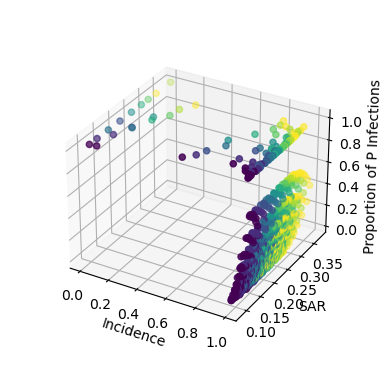

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect(None, zoom = 0.8)

ax.scatter(idcs.flatten(), sars.flatten(), prps.flatten(), c = hh.flatten())
ax.set_xlabel('Incidence')
ax.set_ylabel('SAR')
ax.set_zlabel('Proportion of P Infections')

Text(0.5, 0, 'Proportion of P Infections')

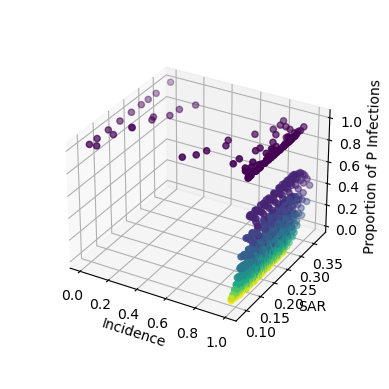

In [47]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect(None, zoom = 0.8)

ax.scatter(idcs.flatten(), sars.flatten(), prps.flatten(), c = cc.flatten())
ax.set_xlabel('Incidence')
ax.set_ylabel('SAR')
ax.set_zlabel('Proportion of P Infections')

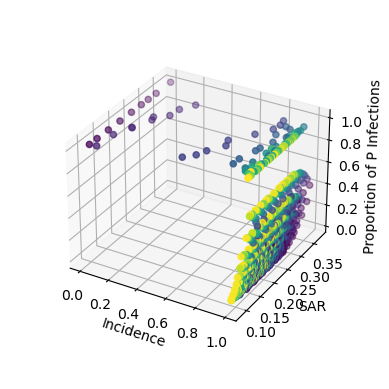

In [48]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect(None, zoom = 0.8)

ax.set_xlabel('Incidence')
ax.set_ylabel('SAR')
ax.set_zlabel('Proportion of P Infections')
ax.scatter(idcs.flatten(), sars.flatten(), prps.flatten(), c = ee.flatten())

For getting the distributions of $\beta_C$ and $\beta_H$, use the distribution of the explored values.